<a href="https://colab.research.google.com/github/arashfahim/Deep-Schemes-for-Control/blob/main/Dr_Fahim_First_Approach_(Final_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [149]:
# from google.colab import drive,files
# drive.mount('/content/gdrive')

In [150]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
import math

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#$n=1 \quad (d=2)$

In [151]:
dim=2
kappa=torch.tensor([1]).to(device)
theta=torch.tensor([0.4]).to(device)
nu=torch.tensor([0.02]).to(device)
lamb=torch.tensor([0.15]).to(device)
eta=torch.tensor([0.5]).to(device)
rho=torch.tensor([0.0]).to(device)

#$n=2 \quad (d=3)$


In [152]:
# dim=3
# kappa=torch.tensor([1,0.8]).to(device)
# theta=torch.tensor([0.1,0.2]).to(device)
# nu=torch.tensor([0.02,0.015]).to(device)
# lamb=torch.tensor([0.15,0.11]).to(device)
# eta=torch.tensor([1]).to(device)
# rho=torch.tensor([0.0,0.0]).to(device)

#$n=4 \quad (d=5)$


In [153]:
# dim=5
# kappa=torch.tensor([1,0.8,0.6,0.4]).to(device)
# theta=torch.tensor([0.1,0.2,0.3,0.4]).to(device)
# nu=torch.tensor([0.02,0.015,0.11,0.12]).to(device)
# lamb=torch.tensor([0.15,0.11,0.12,0.13]).to(device)
# eta=torch.tensor([1]).to(device)
# rho=torch.tensor([0.0,0.0,0.0,0.0]).to(device)

#$n=9 \quad (d=10)$

In [154]:
# dim=10
# kappa=torch.tensor([1,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device)
# theta=torch.tensor([0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device)
# nu=torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device)
# lamb=torch.tensor([0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device)
# eta=torch.tensor([1]).to(device)
# rho=torch.tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device)

In [155]:
# print(num_sample)
# print(num_sample/2)

# Hyperparameters

In [156]:
num_sample=2**8   #M
#dim=5
num_time_interval=20    #N
T=torch.tensor([1]).to(device)
delta_t = torch.tensor(T/ num_time_interval)
# t_steps = torch.linspace(0,1,num_time_interval).to(device)
# sqrt_delta_t = torch.sqrt(delta_t).to(device)
sqrt_delta_t = torch.sqrt(delta_t).to(device)
x_init = torch.zeros(dim)
# sigma=torch.sqrt(torch.tensor([2.0]))
# lamb=torch.tensor([1.0]).to(device)
mu=torch.tensor([1.0]).to(device)
# sigma=torch.tensor([1.0]).to(device)
alpha=torch.tensor([1.0]).to(device)
start = torch.tensor([0]).to(device)
end = torch.tensor([1]).to(device)
num_steps=5
num_ite=int(num_time_interval/num_steps)
# kappa=torch.tensor([1]).to(device)
# theta=torch.tensor([0.4]).to(device)
# nu=torch.tensor([0.5]).to(device)
# lamb=torch.tensor([0.6]).to(device)
# eta=torch.tensor([0.5]).to(device)
p=torch.tensor([0.95]).to(device)
# rho=torch.tensor([0]).to(device)
num_runs=1
# x0=torch.ones([1,dim]).to(device)+4
# print(x0)

t_steps = torch.linspace(0,T.item(),num_time_interval+1).to(device)
# print(t_steps)
test_interval=[0.5,1.5]
# v=(torch.ones(num_sample,dim,dim)-0.3).to(device)
# v=(torch.ones(num_sample,dim,dim)).to(device)
v=torch.diag(torch.ones(dim)).to(device)
# print(v)
v=v.unsqueeze(0).repeat(num_sample,1,1)
print(v.shape)
# print(v)


# dt=T/num_time_interval
Dt=torch.zeros((num_sample,1,num_time_interval+1)).to(device)
print(Dt.shape)
Dt[:,:,1:]=delta_t
t=torch.cumsum(Dt,axis=2).to(device)

torch.Size([256, 2, 2])
torch.Size([256, 1, 21])


/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_20528/1538185290.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_t = torch.tensor(T/ num_time_interval)


# Functions

In [157]:
def H(x,z,gamma): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],gamma shape= [M,dim,dim]
  result=torch.zeros([x.shape[0]]).to(device)
  for i in range(dim-1):
    result+=kappa[i]*(theta[i]-x[:,i+1,0])*z[:,i+1,0]+0.5*torch.pow(nu[i],2)*gamma[:,i+1,i+1]-rho[i]*lamb[i]*nu[i]*(z[:,0,0]*gamma[:,0,i+1])/gamma[:,0,0] \
    + 0.5*torch.pow(rho[i]*nu[i]*gamma[:,0,i+1],2)/gamma[:,0,0]
    # print(result)
  result1=result-0.5*torch.sum(torch.square(lamb))*torch.pow(z[:,0,0],2)/gamma[:,0,0]
  return result1


def F(x,z,a): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
  result=torch.zeros([x.shape[0]]).to(device)
  for i in range(dim-1):
    result+=-kappa[i]*(theta[i]-x[:,i+1,0])*z[:,i+1,0]
    # print(result)
  result1=result-torch.sqrt(torch.sum(torch.square(lamb)))*torch.abs(z[:,0,0])*torch.sqrt(a[:,0,0])
  return result1


def g1(x): #out_shape= [M,1,1]   | input:  x_shape=[M,D]
  result=1-torch.exp(-eta*x[:,0])
  # result=torch.reshape(result,(result.shape[0],1,1))
  result=torch.reshape(result,(result.shape[0],1))
  return result

def update(data,delta_w,L):#output: data=(M,D,1) ,  #input data=(M,D,1), delta_w=[M,D,1]
    dx = torch.bmm(L,delta_w)
    data = data + dx
    data=data
    return data

def der1(x,f):  #output= [M,D,1], input: x=[M,D,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  u=f(xin)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                          allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
  # print('Du shape before reshaped', Du.shape)
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  # print('Du shape after reshaped', Du.shape)
  return Du


def grad_hessian1(t, x,f_): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)

    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)



    # xt_in.requires_grad=True
    u=f_(xt_in)
    # print("u shape: ",u.shape)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    # print("Du shape:",Du.shape)
    # print("-----")
    # print(torch.autograd.grad(outputs=[Du[:,0,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,0,:]),
    #                        allow_unused=True,retain_graph=True,create_graph=True)[0].shape)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)
    # print("D2u shape:",hess_temp.shape)
    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))
    # print("D2u after reshape:",hess_temp.shape)

    # print(hess_temp)
    return Du, hess_temp


def grad_model(t, x,f_): #output= [M,D,1], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)

    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)

    # xt_in.requires_grad=True
    u=f_(xt_in)
    # print("u shape: ",u.shape)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)

    Du = torch.reshape(Du,(Du.shape[0],dim,1))
    # print("Du after reshape:",Du.shape)

    return Du


def hessian_model(t,x,model):
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    Du=torch.zeros(x.shape[0],dim).to(device)

    xin=x.clone().detach()
    xin.requires_grad=True
    # print("xin_shape", xin.shape)
    tin=t.clone().detach()
    # print("tin shape", tin.shape)
    xt_in=torch.cat((xin,tin),1)
    # print("xt_in shape", xt_in.shape)
    Du = model(xt_in)
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)

    # print("D2u shape:",hess_temp.shape)

    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))

    # print(hess_temp)
    return hess_temp



def hessian1(x,model2z):  #x=[M,D,1]  output= [M,D,1]
    hess_temp=torch.zeros(x.shape[0],dim,dim).to(device)
    # print("D2u shape:",hess_temp.shape)

    Du=torch.zeros(x.shape[0],dim).to(device)
    xin=x.clone().detach()
    # print('this is xin')
    # print(xin)
    xin.requires_grad=True
    Du = model2z(xin.squeeze(2))
    # print('this is Du')
    # print(Du)
    # print('this is Du shape')
    # print(Du.shape)
    # print('this is Du 1')
    # print(Du[:,1,:])
    hess_temp= torch.cat([ torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(dim)],1)

    # print("D2u shape:",hess_temp.shape)

    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],dim,dim))

    # print(hess_temp)
    return hess_temp


def grad_fn2(x,z,a,f,xx=False,r=False,p=False,alpha=False):  #output= [M,D,1], input: x=[M,D,1] z=[M,D,1], a=[M,D,D]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # print('xin shape', xin.shape)
  zin=z.clone().detach()
  zin.requires_grad=True
  # print('zin shape', zin.shape)
  ain=a.clone().detach()
  ain.requires_grad=True
  # print('ain shape', ain.shape)
  # ain=torch.reshape(ain,(num_sample,dim*dim,1))
  u=f(xin,zin,ain)
  # print(u)
  # print('u/f(xin) shape', u.shape)
  if xx==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,1))
    # print('Du shape after reshaped', Du.shape)
  if r==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[rin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],1,1))
    # Du=torch.reshape(Du,(Du.shape[0],dim,dim))
    # print('Du shape after reshaped', Du.shape)
  if p==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[zin],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,1))
    # print('Du shape after reshaped', Du.shape)
  if alpha==True:
    Du=torch.autograd.grad(outputs=[u],inputs=[ain],grad_outputs=torch.ones_like(u),
                            allow_unused=True,retain_graph=True,create_graph=True)[0]
    # print('Du shape before reshaped', Du.shape)
    Du=torch.reshape(Du,(Du.shape[0],dim,dim))
    # print('Du shape after reshaped', Du.shape)

  return Du





def L_matrix(ite,x,model):  #x=[M,D]
  L=torch.zeros(x.shape[0],dim,dim)

  L[:,0,0]=model[ite](x)
  for i in range(dim-1):
    L[:,i+1,i+1]=nu[i]
  return L
def opt_quad():
  return torch.pow(torch.sum(torch.pow(lamb,2)),0.5)/eta

# def L_matrix_test(ite,x,model1):  #This matrix is a matrix with L00 = 0.6 and L11=nu
#   L=torch.zeros(x.shape[0],dim,dim)
#   L[:,0,0]=opt_quad()
#   for i in range(dim-1):
#     L[:,i+1,i+1]=nu[i]
#   return L

def L_matrix_test(x):  #This matrix is a matrix with L00 = 0.6 and L11=nu
  L=torch.zeros(x.shape[0],dim,dim)
  L[:,0,0]=opt_quad()
  for i in range(dim-1):
    L[:,i+1,i+1]=nu[i]
  return L

def V1(t,x,v):
  # result=(1-torch.exp(-eta*x))*(torch.exp(-0.5*(T-t)*torch.sum(torch.pow(lamb,2))))
  result=-torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result

def V(t,x,v): #output           |#input:
  result=1-torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result


def V1(t,x,v):
  # result=(1-torch.exp(-eta*x))*(torch.exp(-0.5*(T-t)*torch.sum(torch.pow(lamb,2))))
  result=-torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result

def derV(t,x,v): #output           |#input:
  result=eta*torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result

def hessianV(t,x,v): #output           |#input:
  result=-torch.pow(eta,2)*torch.exp(-eta*x-0.5*(T-t)*torch.sum(torch.pow(lamb,2))).to(device)
  return result

In [158]:
# x_test=torch.ones(2,dim,1).float().to(device)
# z_test=torch.ones(2,dim,1).float().to(device)
# a_test=torch.ones(2,dim,dim).float().to(device)
# derivative_alpha=grad_fn2(x_test,z_test,a_test,F,alpha=True)
# print(derivative_alpha)

In [159]:
# derivative_z=grad_fn2(x_test,z_test,a_test,F,p=True)
# print(derivative_z)

In [160]:
# print(kappa)
# print(lamb)
# print(-lamb/2)

In [161]:
# a_test.requires_grad_()
# u=F(x_test,z_test,a_test)
# gd =torch.autograd.grad(outputs=u[0],inputs=a_test,retain_graph=True,create_graph=True)[0]
# print(gd)

In [162]:
# delta=0.00001
# with torch.no_grad():
#   u1=F(x_test,z_test,a_test)
#   u2=F(x_test,z_test,a_test+delta)
# print((u2-u1)/delta)

In [163]:
print(opt_quad())

tensor([0.3000])


## T Generator Function

In [164]:
def t_generator(size):
  Dt=torch.zeros((size,1,num_time_interval+1)).to(device)
  Dt[:,:,1:]=delta_t
  t=torch.cumsum(Dt,axis=2).to(device)
  return t

## Plot Function

In [165]:
def plot(start,end,steps, t_test, ite,model,modely=False, modelz=False,modelv=False):
  xs = torch.linspace(start, end, steps=steps)
  # print(xs)
  ys = torch.linspace(start,end, steps=steps)
  # print(ys)
  xgrid, ygrid = torch.meshgrid(xs, ys, indexing='xy')
  # print(xgrid)
#  print(xgrid.shape)
  # print(ygrid)
  # print(xgrid.flatten().shape)
  sss=torch.stack((xgrid.flatten(),ygrid.flatten()),1).to(device)
  # print(sss)
  # print(sss.shape)

  t=t_generator(steps*steps)
  sss_t=torch.cat((sss,t[:,:,t_test]),1)
  # print(sss_t)

  if modelz==True:
    z=model(sss_t).clone().detach().cpu()
    # print(z.shape)
    z=torch.reshape(z,(steps,steps))
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    # ax=plt.axes(projection='3d')
    ax.plot_surface(xgrid.numpy(), ygrid.numpy(), z.numpy(),label = "trained_modelY")


    truez = derV(t_steps[t_test],xgrid.to(device),ygrid.to(device)).clone().detach().cpu()
    # print("This is theoretical solution")
    # print(truey)
    true_matrixz=torch.reshape(truez,(steps,steps))
    # print(true_matrix.shape)
    # ax = plt.axes(projection='3d')
    ax.plot_surface(xgrid.numpy(), ygrid.numpy(), true_matrixy.numpy(),label = "True")

    ax.set_title("MSE of the trained model Y at timestep {}: {:.7f}".format(t_test,np.mean(np.square(true_matrixz.numpy()-z.numpy()))))
    ax.set_xlabel(r'x', fontsize=15, rotation=70)
    ax.set_ylabel(r'v', fontsize=15, rotation=60)
    plt.show()
  if modelv==True:
    z1=model[ite](sss_t).clone().detach().cpu()
    # print(z.shape)
    z1=torch.reshape(z1,(steps,steps))
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    # ax=plt.axes(projection='3d')
    ax.plot_surface(xgrid.numpy(), ygrid.numpy(), z1.numpy(),label = "trained_modelV")


    trueV = torch.zeros(steps,steps)

    # true_matrixV=torch.reshape(truey,(steps,steps))
    # print(true_matrix.shape)
    # ax = plt.axes(projection='3d')
    ax.plot_surface(xgrid.numpy(), ygrid.numpy(), trueV.numpy(),label = "True")

    ax.set_title("MSE of the trained model V at timestep {}: {:.7f}".format(t_test,np.mean(np.square(trueV.numpy()-z1.numpy()))))
    ax.set_xlabel(r'x', fontsize=15, rotation=70)
    ax.set_ylabel(r'v', fontsize=15, rotation=60)
    plt.show()
  if modely==True:
    z=model(sss_t).clone().detach().cpu()
    # print(z.shape)
    z=torch.reshape(z,(steps,steps))
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    # ax=plt.axes(projection='3d')
    ax.plot_surface(xgrid.numpy(), ygrid.numpy(), z.numpy(),label = "trained_modelY")


    truey = V(t_steps[t_test],xgrid.to(device),ygrid.to(device)).clone().detach().cpu()
    # print("This is theoretical solution")
    # print(truey)
    true_matrixy=torch.reshape(truey,(steps,steps))
    # print(true_matrix.shape)
    # ax = plt.axes(projection='3d')
    ax.plot_surface(xgrid.numpy(), ygrid.numpy(), true_matrixy.numpy(),label = "True")

    ax.set_title("MSE of the trained model Y at timestep {}: {:.7f}".format(t_test,np.mean(np.square(true_matrixy.numpy()-z.numpy()))))
    ax.set_xlabel(r'x', fontsize=15, rotation=70)
    ax.set_ylabel(r'v', fontsize=15, rotation=60)
    plt.show()

## Mean Error Funcion

In [166]:
size=1000
test_samples=[(test_interval[0]+(test_interval[1]-test_interval[0])*torch.rand(size).to(device)) for i in range(dim)]

In [167]:
def mean_error(test_samples,start,end,t_test, ite,model,modely=False, modelz=False,modelv=False):
  # test_samples=[(start+(end-start)*torch.rand(size).to(device)) for i in range(dim)]
  sss = torch.stack(test_samples,dim=1)
  t=t_generator(size)
  sss_t=torch.cat((sss,t[:,:,t_test]),1)


  # print(sss_t.shape)

  # if modelz==True:

  #   z=model(sss_t).clone().detach().cpu()
  #   truez = derV(t_steps[t_test],xgrid.to(device),ygrid.to(device)).clone().detach().cpu()

  #   print("MSE of the trained model Y at timestep {}: {:.7f}".format(t_test,np.mean(np.square(z-truez))))


  # if modelv==True:
  #   z1=model[ite](sss_t).clone().detach().cpu()


    # trueV = torch.zeros(steps,steps)


    # print("MSE of the trained model V at timestep {}: {:.7f}".format(t_test,np.mean(np.square(trueV.numpy()-z1.numpy()))))

  if modely==True:
    z2=model(sss_t).clone().detach().cpu()
    # print(z2.shape)
    truey = V(t_test,sss_t[:,0],sss_t[:,1:]).clone().detach().cpu()
    # print(truey.shape)

    # print("MSE of the trained model Y at timestep {}: {:.7f}".format(t_test,np.mean(np.square(truey.numpy()-z2.numpy()))))
    error=[np.mean(np.absolute(truey.numpy()-z2.numpy())/truey.numpy()),np.mean(np.square(truey.numpy()-z2.numpy()))]
    return error
    # return np.mean(np.absolute(truey.numpy()-z2.numpy())/z2.numpy()),np.mean(np.square(truey.numpy()-z2.numpy()))

In [168]:
x=np.array(3-4)
print(np.absolute(x))

1


In [169]:
  # t=t_generator(3*3)
  # print(t.shape)
  # print(t[:,:,20])


In [170]:
def grad_mean(start,end,steps,model,s):
  xs = torch.linspace(start, end, steps=steps)
  ys = torch.linspace(start,end, steps=steps)

  xgrid, ygrid = torch.meshgrid(xs, ys, indexing='xy')
  sss=torch.stack((xgrid.flatten(),ygrid.flatten()),1).to(device)
  t=t_generator(steps*steps)
  accum_mean=0
  # sss_t=torch.cat((sss,t[:,:,20]),1)
  # print(torch.mean(torch.mean(model[s](sss_t))))
  for i in range(0,num_time_interval+1):
    sss_t=torch.cat((sss,t[:,:,i]),1)
    # print(model[s](sss_t).shape)
    accum_mean+=torch.mean(torch.abs(model[s](sss_t)))
  return accum_mean/num_time_interval



In [171]:
# mean1=grad_mean(test_interval[0],test_interval[1],100,modelV,0)
# print(mean1)
# mean2=grad_mean(test_interval[0],test_interval[1],100,loaded_model_V_new,0)
# print(mean2)

#Two Criterions:  Less Than Thresshold or Difference between s and s+1 less than a threshold

In [172]:
print(opt_quad())

tensor([0.3000])


In [173]:
def gradient(x,f): #input=  [M,D,1]    #output= [M,D,1]
  xin=x.clone().detach()
  xin.requires_grad=True
  u=f(xin.squeeze(2));
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),allow_unused=True,retain_graph=True,create_graph=True)[0]
  return Du

# Initilizing Models

In [174]:
class ann(nn.Module): #input [M,D+1]   #output [M,1]

    def __init__(self):
        super(ann, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(dim+1, 128),
            nn.BatchNorm1d(num_features=128),
            # nn.Tanh(),
            # nn.Linear(128,128),
            # nn.BatchNorm1d(num_features=128),
            nn.Tanh(),
            nn.Linear(128,128),
            nn.BatchNorm1d(num_features=128),
            nn.Tanh(),
            # nn.Linear(128, 128),
            # nn.BatchNorm1d(num_features=128),
            # nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            nn.Linear(128,1),
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [175]:
class annz(nn.Module):

    def __init__(self):
        super(annz, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(dim+1, 128),
            nn.BatchNorm1d(num_features=128),
            nn.Tanh(),
            nn.Linear(128,128),
            nn.BatchNorm1d(num_features=128),
            nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(num_features=64),
            nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            nn.Linear(64,dim),
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [176]:
class annsigma(nn.Module):

    def __init__(self):
        super(annsigma, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(dim+1, 128),
            nn.BatchNorm1d(num_features=128),
            nn.Tanh(),
            # nn.Linear(256,128),
            # nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(num_features=128),
            nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            # nn.Linear(128,128),
            # nn.Tanh(),
            nn.Linear(128,128),
            nn.Tanh(),
            nn.Linear(128,dim*dim),
        )
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        # print(logits.shape)
        logits=torch.reshape(logits,(-1,dim,dim))
        return logits

In [177]:
print(dim*dim*num_time_interval)

80


In [178]:
# num_max_ite=30
modelY=ann().to(device)
modelZ=annz().to(device)
# modelV= nn.ModuleList([ann() for i in range(num_max_ite+1)]).to(device)
# modelderV= nn.ModuleList([annz() for i in range(num_max_ite+1)]).to(device)


modelV= ann().to(device)
modelderV= annz().to(device)
# modelsigma=ann().to(device)
# temp=modelZ.copy()

# copy.deepcopy()
# temp=copy.deepcopy(modelZ)
# aa=torch.rand(num_sample,dim+1).to(device)
# print(modelZ(aa))
# print(temp(aa))
modelsigma=annsigma().to(device)

In [179]:
# print(modelsigma(aa).shape)
# print(modelsigma(aa)[:,:,1].shape)

In [180]:
# print(sigma_init[:,:,:,1].shape)

# Sigma_init

In [181]:
sigma_init=torch.zeros(num_sample,dim,dim,num_time_interval).to(device)
x_sample = torch.zeros([num_sample,dim, num_time_interval + 1]).to(device)
for i in range(num_time_interval):
  sigma_init[:,:,:,i]=L_matrix_test(x_sample)+torch.diag(torch.ones(dim))# modify the proper sigma with a constant to initialize it
  # sigma_init[:,:,:,i]=L_matrix_test(x_sample)
  # sigma_init[:,:,:,i]=L_matrix_test(x_sample)
  # sigma_init[:,:,:,i]=sigma_init[:,:,:,i]
print(sigma_init.shape)
xinit=torch.tensor([0]).to(device)
# print(sigma_init[:,:,:,2])
# print(sigma_init[:,:,:,2]**2)

torch.Size([256, 2, 2, 20])


In [182]:
# print((modelsigma(aa)[:,:,:,1]-sigma_init[:,:,:,1]).shape)
# print(torch.mean(torch.square((modelsigma(aa)[:,:,:,1]-sigma_init[:,:,:,1]))).shape)

# Update_Sigma Function

In [183]:
def update_sigma(sigma_init,modelsigma):
  for ite in range(0,num_time_interval):
      xt=torch.cat((x_sample[:,:,ite],t[:,:,ite]),1).to(device)
      sigma_init[:,:,:,ite]=modelsigma(xt)
  return sigma_init

In [184]:
# def update_sigma(s,i,lr): #output:               | #input
#   result=torch.zeros(num_sample, 1).to(device)
#   xt=torch.cat((x_sample[:,:,i],t[:,:,i]),1).to(device)
#   # print('this is xt shape', xt.shape)
#   sigma=torch.randn(num_sample,dim,dim).to(device)
#   # print(sigma)
#   for j in range(s):
#     result=result+modelV[j](xt)
#   # print((v.reshape(num_sample,dim*dim)*result).reshape(num_sample,dim,dim))
#   return sigma+lr*(v.reshape(num_sample,dim*dim)*result).reshape(num_sample,dim,dim)


# def update_sigma(sigma,s,i,lr): #output:               | #input
#   result=torch.zeros(num_sample, 1).to(device)
#   xt=torch.cat((x_sample[:,:,i],t[:,:,i]),1).to(device)
#   # print('this is xt shape', xt.shape)

#   for j in range(s):
#     result=result+modelV[j](xt)
#   # print((v.reshape(num_sample,dim*dim)*result).reshape(num_sample,dim,dim))
#   return sigma+lr*(v.reshape(num_sample,dim*dim)*result).reshape(num_sample,dim,dim)

# def update_sigma(sigma_init,time_step,s,v,lr):
#   result=sigma_init.clone()
#   xt=torch.cat((x_sample[:,:,time_step],t[:,:,time_step]),1).to(device)
#   for i in range(s):
#     # print(modelV[i](xt))
#     # print(modelV[i](xt).unsqueeze(2)*v)
#     result[:,:,:,time_step]=result[:,:,:,time_step]+lr*(modelV[i](xt).unsqueeze(2)*v)
#     # print(result[:,:,:,time_step])
#   # print(result[:,:,:,time_step])
#   return result[:,:,:,time_step]
#   #   sigma_init[:,:,:,time_step]=sigma_init[:,:,:,time_step]+lr*(modelV[j](xt).unsqueeze(2)*v)
#   # return sigma_init[:,:,:,time_step]
# def update_sigma(sigma_init,time_step,s,v,lr):
#   result=sigma_init.clone()
#   if s==0:
#     result[:,:,:,time_step]=sigma[:,:,:,time_step]
#   else:
#     xt=torch.cat((x_sample[:,:,time_step],t[:,:,time_step]),1).to(device)
#     result[:,:,:,time_step]=result[:,:,:,time_step]+lr*(modelsigma(xt).unsqueeze(2)*v)
#   return result[:,:,:,time_step]

# Net Functions

In [185]:
def net_u( x,t): #output:               | #input:  x=[M,D], t=[M,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # xin=x.clone().detach()
  # tin=t.clone().detach()
  # # print(xin)
  # xin.requires_grad=True
  # xcat=torch.cat((xin,tin),1)
  xcat=torch.cat((xin,t),1)
  # print(xcat.shape)
  u=modelY(xcat).to(device)
  # print(u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),allow_unused=True,retain_graph=True,create_graph=True)[0]
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  return u,Du


def net_z( x,t): #output:               | #input:  x=[M,D], t=[M,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # xin=x.clone().detach()
  # tin=t.clone().detach()
  # # print(xin)
  # xin.requires_grad=True
  # xcat=torch.cat((xin,tin),1)
  xcat=torch.cat((xin,t),1)
  # print(xcat.shape)
  z=modelZ(xcat).to(device)
  # print(u.shape)

  z=torch.reshape(z,(z.shape[0],dim,1))
  return z
def net_v(x,t): #output:               | #input:  x=[M,D], t=[M,1]
  Du=torch.zeros(x.shape[0],dim).to(device)
  xin=x.clone().detach()
  xin.requires_grad=True
  # xin=x.clone().detach()
  # tin=t.clone().detach()
  # # print(xin)
  # xin.requires_grad=True
  # xcat=torch.cat((xin,tin),1)
  xcat=torch.cat((xin,t),1)
  # print(xcat.shape)
  u=modelV(xcat).to(device)
  # print(u.shape)
  Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),allow_unused=True,retain_graph=True,create_graph=True)[0]
  Du=torch.reshape(Du,(Du.shape[0],dim,1))
  return u,Du

def derg(x):
  x.requires_grad=True
  u=g(x);
  Du=torch.autograd.grad(outputs=[u],inputs=[x],grad_outputs=torch.ones_like(u),allow_unused=True,retain_graph=True,create_graph=True)[0]
  return Du

# Optimizer 1

In [186]:
def opt1(lr_,SGD=False, Adam=False):

  if SGD==True:
    # optimizer=optim.SGD(list(modelY.parameters())+list(modelZ.parameters()),lr=lr_,momentum=0.9)
    optimizer=optim.SGD(list(modelY.parameters())+list(modelZ.parameters()),lr=lr_)
  if Adam==True:
    # optimizer=optim.Adam(modelV[s].parameters(),lr=lr_,weight_decay=1e-5)
    optimizer=optim.Adam(list(modelY.parameters())+list(modelZ.parameters()),lr=lr_)
# opt = SGD(lr=0.01, momentum=0.9)
  # scheduler=ExponentialLR(optimizer,gamma=0.9)
  return optimizer

# Loss Function 1


In [187]:
def loss_fn1(x_sample,dw_sample,temp_index):
    loss1=0
    Y0,dY0=net_u(x_sample[temp_index,:,0],t[temp_index,:,0])
    Z0=net_z(x_sample[temp_index,:,0],t[temp_index,:,0])
    loss1=loss1+torch.mean(torch.mean(torch.square(dY0-Z0),1))
    for ite in range(0,num_time_interval):
      Y_pred=Y0+F(x_sample[temp_index,:,ite].unsqueeze(2),Z0,(sigma_init[temp_index,:,:,ite]**2)).unsqueeze(1)*delta_t+torch.bmm(torch.bmm(torch.transpose(Z0,1,2),sigma_init[temp_index,:,:,ite]),dw_sample[temp_index,:,ite].unsqueeze(2)).squeeze(2)
      Y1,dY1=net_u(x_sample[temp_index,:,ite+1],t[temp_index,:,ite+1])
      Z1=net_z(x_sample[temp_index,:,ite+1],t[temp_index,:,ite+1])
      Y0=Y1
      Z0=Z1
      # print(Z1)
      if ite==num_time_interval-1:
        loss1=loss1+torch.mean(torch.square(Y_pred-g1(x_sample[temp_index,:,ite+1])))
        loss1=loss1+torch.mean(torch.mean(torch.square(Z1-der1(x_sample[temp_index,:,ite+1],g1)),1))
      if ite != num_time_interval-1:
        loss1=loss1+torch.mean(torch.mean(torch.square(Y_pred-Y1),1))
        loss1=loss1+torch.mean(torch.mean(torch.square(dY1-Z1),1))
    return loss1


# Optimizer 2

In [188]:
def opt2(lr_,SGD=False, Adam=False):

  if SGD==True:
    # optimizer=optim.SGD(modelV[s].parameters(),lr=lr_,momentum=0.9)
    optimizer=optim.SGD(list(modelV.parameters())+list(modelderV.parameters()),lr=lr_, momentum=0.9)
    # optimizer=optim.SGD(list(modelV[s].parameters())+list(modelderV[s].parameters()),lr=lr_)
  if Adam==True:
    # optimizer=optim.Adam(modelV[s].parameters(),lr=lr_,weight_decay=1e-5)
    # optimizer=optim.Adam(modelV[s].parameters(),lr=lr_)
    optimizer=optim.SGD(list(modelV.parameters())+list(modelderV.parameters()),lr=lr_)

  # scheduler=ExponentialLR(optimizer,gamma=0.9)
  return optimizer


# def opt2(ite,t1,t2):
#   l=[]
#   lr_=lr2[ite]

#   # for i in range(t1,t2+1):
#   #   l+=list(modely2[i].parameters())+list(modelz2[i].parameters())

#   # l=list(modely2[t1].parameters())
#   for i in range(t1,t2+1):
#     l+=list(modely2[i].parameters())
#   # optimizer=optim.Adam(l,lr=0.005)
#   optimizer=optim.SGD(l, lr=lr_, momentum=0.9)
#   # optimizer = torch.optim.Adam(l, lr=lr_, weight_decay=1e-5)
#   # scheduler = ExponentialLR(optimizer, gamma =0.9)
#   return optimizer

# def opt1(lr_,SGD=False, Adam=False):

#   if SGD==True:
#     optimizer=optim.SGD(list(modelY.parameters())+list(modelZ.parameters()),lr=lr_)
#   if Adam==True:
#     # optimizer=optim.Adam(modelV[s].parameters(),lr=lr_,weight_decay=1e-5)
#     optimizer=optim.Adam(list(modelY.parameters())+list(modelZ.parameters()),lr=lr_)

#   # scheduler=ExponentialLR(optimizer,gamma=0.9)
#   return optimizer

# Loss Function 2



In [189]:
def loss_fn2(x_sample,dw_sample,temp_index):
  loss2=0
  V0,dV0=net_v(x_sample[temp_index,:,0],t[temp_index,:,0])
  derV0=modelderV(torch.cat((x_sample[temp_index,:,0],t[temp_index,:,0]),1))
  loss2=loss2+torch.mean(torch.mean(torch.square(dV0.squeeze(2)-derV0),1))

  Z0=modelZ(torch.cat((t[temp_index,:,0],x_sample[temp_index,:,0]),1)).unsqueeze(2)
  # print(Z0.shape)
  # xcat=torch.cat((xin,t),1)


  dZ0=hessian_model(t[temp_index,:,0],x_sample[temp_index,:,0],modelZ)
  # print(dZ0.shape)
  # Z0,dZ0=grad_hessian1(t[:,:,0],x_sample[:,:,0],modelY)

  for ite in range(0,num_time_interval):
    V_pred=V0.flatten() +\
    (-torch.sum(torch.bmm(torch.transpose(sigma_init[temp_index,:,:,ite],1,2),v[temp_index,:,:])*dZ0,(1,2))+\
    torch.sum(v[temp_index,:,:]*grad_fn2(x_sample[temp_index,:,ite].unsqueeze(2),Z0,sigma_init[temp_index,:,:,ite],F,alpha=True),(1,2))+ \
    torch.sum(grad_fn2(x_sample[temp_index,:,ite].unsqueeze(2),Z0,sigma_init[temp_index,:,:,ite],F,p=True)*dV0,(1,2)))*dt+\
    torch.sum(torch.bmm(torch.bmm(torch.transpose(dV0,1,2),sigma_init[temp_index,:,:,ite]),dw_sample[temp_index,:,ite].unsqueeze(2)),(1,2))

    V1,dV1=net_v(x_sample[temp_index,:,ite+1],t[temp_index,:,ite+1])
    # Z0,dZ0=grad_hessian1(t[:,:,ite+1],x_sample[:,:,ite+1],modelY)

    Z0=modelZ(torch.cat((t[temp_index,:,ite+1],x_sample[temp_index,:,ite+1]),1)).unsqueeze(2)
    dZ0=hessian_model(t[temp_index,:,ite+1],x_sample[temp_index,:,ite+1],modelZ)

    derV1=modelderV(torch.cat((x_sample[temp_index,:,ite+1],t[temp_index,:,ite+1]),1))

    V0=V1
    dV0=dV1
    if ite==num_time_interval-1:
      loss2=loss2+torch.mean(torch.square(V_pred))
      loss2=loss2+torch.mean(torch.mean(torch.square(derV1),1))
      loss2=loss2+torch.mean(torch.mean(torch.square(dV1)))
    else:
      loss2=loss2+torch.mean(torch.mean(torch.square(V_pred-V1.flatten())))
      loss2=loss2+torch.mean(torch.mean(torch.square(dV1.squeeze(2)-derV1),1))
  return loss2




# Optimizer 3

In [190]:
def opt3(lr_,SGD=False, Adam=False):

  if SGD==True:
    # optimizer=optim.SGD(list(modelY.parameters())+list(modelZ.parameters()),lr=lr_,momentum=0.9)
    optimizer=optim.SGD(modelsigma.parameters(),lr=lr_)
  if Adam==True:
    # optimizer=optim.Adam(modelV[s].parameters(),lr=lr_,weight_decay=1e-5)
    optimizer=optim.Adam(modelsigma.parameters(),lr=lr_)
  return optimizer

# Los Function 3

In [191]:
def loss_fn3(x_sample,dw_sample,temp_index):
  loss3=0
  for ite in range(0,num_time_interval):
    xt=torch.cat((x_sample[temp_index,:,ite],t[temp_index,:,ite]),1).to(device)
    loss3+=torch.mean(torch.square(modelsigma(xt)-(sigma_init[temp_index,:,:,ite]+lr*(modelV(xt).unsqueeze(2)*v[temp_index,:,:]))))
  return loss3


# Train Both Models (ModelY and ModelV)

In [192]:
num_max_ite=30
num_epoch_1=100
num_epoch_2=100
num_epoch_3=20
# optimizer1=opt1(0.0005,Adam=True)
# optimizer2=opt2(0,0.0005,Adam=True)
lr1=0.001
lr2=0.001
lr3=0.001



lr=0.05
# batch_size=64*2*2
batch_size=int(num_sample/16)
# batch_size=int(num_sample)
print(type(batch_size))
num_runs=1

<class 'int'>


In [193]:
index=0
last_loss1 = 0
last_loss2=0
last_loss3=0
loss_delta1 = 0
loss_delta2=0
loss_delta3=0
loss_treshold1 = 0
loss_treshold2=0
loss_treshold3=0
loss_tmp1=[]
loss_tmp2=[]
loss_tmp3=[]


average_error=0
average_std=0

#Train both models with Loss Functions

In [194]:
# optimizer1=opt1(0.000001,SGD=True)
model1results=[]
for r in range(num_runs):
    print('----------------------------------------------------------------------------------------------------------------------------------------')
    print("This is {}th run".format(r+1))
    model1_mean_error_timestep0=[]
    model1_mean_error_timestep5=[]
    model1_mean_error_timestep10=[]
    # model1_rel_error_timestep0=[]
    # model1_rel_error_timestep5=[]
    # model1_rel_error_timestep10=[]

    modelY=ann().to(device)
    modelZ=annz().to(device)
    modelV= ann().to(device)
    modelsigma=annsigma().to(device)
    for i in range(num_max_ite+1):
      if i!=0:
        sigma_init=update_sigma(sigma_init,modelsigma)
########################################### optimization #1 ##########################################################################
      optimizer1=opt1(lr1,SGD=True)
      losslist1=[]
      print('--------------------------------------------------------')
      print('---This is iteration ',i+1)
      # modelY=ann().to(device)
      # modelZ=annz().to(device)
      dw_sample = torch.randn(size=[num_sample, dim, num_time_interval]).to(device)* sqrt_delta_t
      x_sample = torch.zeros([num_sample,dim, num_time_interval + 1]).to(device)
      x_sample[:, :, 0] = test_interval[0]+(test_interval[1]-test_interval[0])*(torch.rand(num_sample,dim))
      my_index=torch.arange(x_sample.shape[0])
      total_batch=int((x_sample.shape[0]/batch_size))


      for j in range(num_time_interval):
        x_sample[:, :, j + 1] = x_sample[:, :, j] + torch.bmm(sigma_init[:,:,:,j],dw_sample[:, :, j].unsqueeze(2)).squeeze(2)

      print('-----This is loop 1')
      for epoch in range(num_epoch_1):
        t_1=time.time()
        for batch in range(total_batch):
            if batch==total_batch-1:
                  temp_index=my_index[batch*batch_size : ]
            else:
                  temp_index=my_index[batch*batch_size : batch*batch_size + batch_size]
            # print(len(temp_index))
            # print(x_sample[temp_index,:,:].shape)
            optimizer1.zero_grad()
            loss1=loss_fn1(x_sample[:,:,:],dw_sample[:,:,:],temp_index)

            # loss1=loss_fn1(ite,data.unsqueeze(2)[temp_index,:].to(device),delta_w[temp_index,:].unsqueeze(2).to(device),model1[ite-1])
            loss1.backward(retain_graph=True)
            optimizer1.step()
        # losslist1.append(loss1.item())

        loss_tmp1.append(loss1.item())
        loss_delta1 = loss1.item() - last_loss1
        last_loss1 = loss1.item()
        if epoch %20 == 0:
          # print(loss1)
          print("Loss function 1 at epoch {:.0f} is {:.12e}  |  Loss delta: {}   |    Training time: {:.5f}s".format(index*(num_epoch_1)+epoch, loss_delta1,loss1.item(), time.time()-t_1))
      if dim==2:
        # plot(test_interval[0],test_interval[1],100,15,0,modelY,modely=True)
        # plot(test_interval[0],test_interval[1],100,12,0,modelY,modely=True)
        # plot(test_interval[0],test_interval[1],100,10,0,modelY,modely=True)
        plot(test_interval[0],test_interval[1],100,7,0,modelY,modely=True)
        plot(test_interval[0],test_interval[1],100,3,0,modelY,modely=True)
        plot(test_interval[0],test_interval[1],100,1,0,modelY,modely=True)
        plot(test_interval[0],test_interval[1],100,0,0,modelY,modely=True)
      # def mean_error(start,end,size, t_test, ite,model,modely=False, modelz=False,modelv=False):
      else:
        model1_mean_error_timestep0.append(mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True))
        print(mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True))
        # print(model1_mean_error_timestep0)
        # print("Relative Error Percent of the trained model Y at timestep {}: {:.7f}".format(0, mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True)[0]))
        # print("MSE of the trained model Y at timestep {}: {:.7f}".format(0, mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True)[1]))


        model1_mean_error_timestep5.append(mean_error(test_samples,test_interval[0],test_interval[1],5,0,modelY,modely=True))
        print(mean_error(test_samples,test_interval[0],test_interval[1],5,0,modelY,modely=True))
        # print(model1_mean_error_timestep5)
        # print("Relative Error Percent of the trained model Y at timestep {}: {:.7f}".format(5, mean_error(test_samples,test_interval[0],test_interval[1],5,0,modelY,modely=True)[0]))
        # print("MSE of the trained model Y at timestep {}: {:.7f}".format(5, mean_error(test_samples,test_interval[0],test_interval[1],5,0,modelY,modely=True)[1]))


        model1_mean_error_timestep10.append(mean_error(test_samples,test_interval[0],test_interval[1],7,0,modelY,modely=True))
        print(mean_error(test_samples,test_interval[0],test_interval[1],7,0,modelY,modely=True))
        # print(model1_mean_error_timestep10)
        # print("Relative Error Percent of the trained model Y at timestep {}: {:.7f}".format(10, mean_error(test_samples,test_interval[0],test_interval[1],10,0,modelY,modely=True)[0]))
        # print("MSE of the trained model Y at timestep {}: {:.7f}".format(10, mean_error(test_samples,test_interval[0],test_interval[1],10,0,modelY,modely=True)[1]))
########################################### optimization #2 ##########################################################################
      optimizer2=opt2(lr2,SGD=True)
      print('-----This is loop 2')
      for epoch in range(num_epoch_2):
        t_2=time.time()
        for batch in range(total_batch):
            if batch==total_batch-1:
                  temp_index=my_index[batch*batch_size : ]
            else:
                  temp_index=my_index[batch*batch_size : batch*batch_size + batch_size]

            optimizer2.zero_grad()
            loss2=loss_fn1(x_sample[:,:,:],dw_sample[:,:,:],temp_index)

            # loss1=loss_fn1(ite,data.unsqueeze(2)[temp_index,:].to(device),delta_w[temp_index,:].unsqueeze(2).to(device),model1[ite-1])
            loss2.backward(retain_graph=True)
            optimizer2.step()
        # losslist2.append(loss2.item())
        loss_tmp2.append(loss1.item())
        loss_delta2 = loss1.item() - last_loss2
        last_loss2 = loss2.item()
        if epoch %20 == 0:
          # print(loss1)
          print("Loss function 2 at epoch {:.0f} is {:.12e}  |  Loss delta: {}   |    Training time: {:.5f}s".format(index*(num_epoch_2)+epoch, loss_delta2,loss2.item(), time.time()-t_2))
        if epoch %20 == 0:
          print(loss2)
########################################### optimization #3 ##########################################################################
      optimizer3=opt3(lr3,SGD=True)
      # losslist3=[]
      print('-----This is loop 3')
      for epoch in range(num_epoch_3):
        t_3=time.time()
        for batch in range(total_batch):
            if batch==total_batch-1:
                  temp_index=my_index[batch*batch_size : ]
            else:
                  temp_index=my_index[batch*batch_size : batch*batch_size + batch_size]

            optimizer3.zero_grad()
            loss3=loss_fn3(x_sample[:,:,:],dw_sample[:,:,:],temp_index)

            # loss1=loss_fn1(ite,data.unsqueeze(2)[temp_index,:].to(device),delta_w[temp_index,:].unsqueeze(2).to(device),model1[ite-1])
            loss3.backward(retain_graph=True)
            optimizer3.step()
        # losslist3.append(loss3.item())
        loss_tmp3.append(loss3.item())
        loss_delta3 = loss3.item() - last_loss3
        last_loss3 = loss3.item()
        if epoch %20 == 0:
          # print(loss3)
          print("Loss function 3 at epoch {:.0f} is {:.12e}  |  Loss delta: {}   |    Training time: {:.5f}s".format(index*(num_epoch_3)+epoch, loss_delta3,loss3.item(), time.time()-t_3))
      index+=1

      if i==num_max_ite:
        model1results.append(mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True))
        print(model1results)

average_MSE=torch.mean(torch.tensor(model1results))
average_std_MSE=torch.std(torch.tensor(model1results))

print("The average MSE of {} independent runs of model1 at time step {} is {}".format(num_runs,0,average_MSE))
print("The average std MSE of {} independent runs of model1 at time step {} is {}".format(num_runs,0,average_std_MSE))

# print("The relative erorr percent of {} independent runs of model1 at time step {} is {}".format(num_runs,0,relative_error_percent))


----------------------------------------------------------------------------------------------------------------------------------------
This is 1th run


--------------------------------------------------------
---This is iteration  2
-----This is loop 1
Loss function 1 at epoch 100 is 4.430105090141e-01  |  Loss delta: 0.6906274557113647   |    Training time: 22.03530s
Loss function 1 at epoch 120 is 8.046627044678e-06  |  Loss delta: 0.693709671497345   |    Training time: 30.19901s
Loss function 1 at epoch 140 is -6.610155105591e-05  |  Loss delta: 0.6929517984390259   |    Training time: 35.40368s
Loss function 1 at epoch 160 is -9.489059448242e-05  |  Loss delta: 0.6912813186645508   |    Training time: 42.70046s
Loss function 1 at epoch 180 is -1.058578491211e-04  |  Loss delta: 0.6892459988594055   |    Training time: 27.67356s


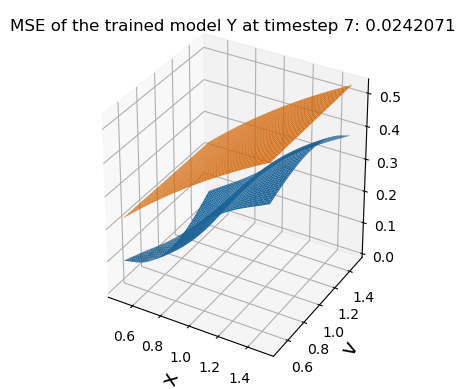

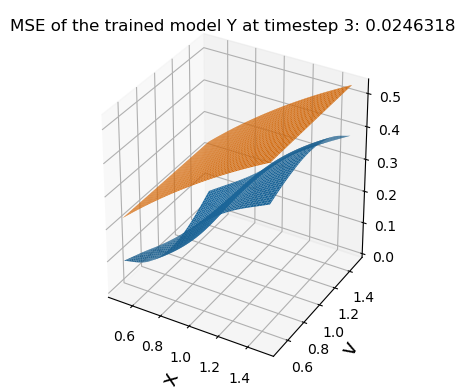

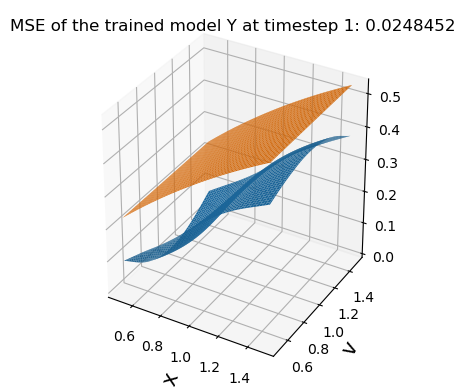

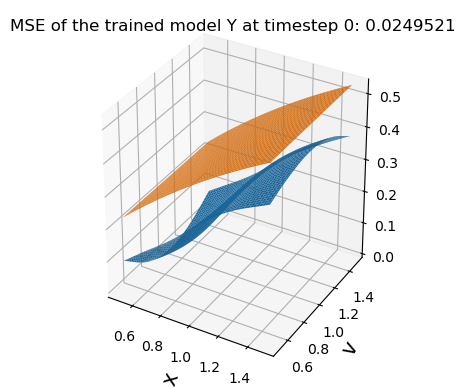

-----This is loop 2
Loss function 2 at epoch 100 is 5.186797678471e-01  |  Loss delta: 0.6764676570892334   |    Training time: 29.28659s
tensor(0.6765, grad_fn=<AddBackward0>)
Loss function 2 at epoch 120 is 1.073336601257e-02  |  Loss delta: 0.6764676570892334   |    Training time: 29.40876s
tensor(0.6765, grad_fn=<AddBackward0>)
Loss function 2 at epoch 140 is 1.073336601257e-02  |  Loss delta: 0.6764676570892334   |    Training time: 955.03421s
tensor(0.6765, grad_fn=<AddBackward0>)
Loss function 2 at epoch 160 is 1.073336601257e-02  |  Loss delta: 0.6764676570892334   |    Training time: 29.12830s
tensor(0.6765, grad_fn=<AddBackward0>)
Loss function 2 at epoch 180 is 1.073336601257e-02  |  Loss delta: 0.6764676570892334   |    Training time: 30.32523s
tensor(0.6765, grad_fn=<AddBackward0>)
-----This is loop 3


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 4]], which is output 0 of AsStridedBackward0, is at version 322; expected version 321 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [201]:
    for i in range(num_max_ite+1):
      if i!=0:
        sigma_init=update_sigma(sigma_init,modelsigma)
########################################### optimization #1 ##########################################################################
      optimizer1=opt1(lr1,SGD=True)
      losslist1=[]
      print('--------------------------------------------------------')
      print('---This is iteration ',i+1)
      # modelY=ann().to(device)
      # modelZ=annz().to(device)
      dw_sample = torch.randn(size=[num_sample, dim, num_time_interval]).to(device)* sqrt_delta_t
      x_sample = torch.zeros([num_sample,dim, num_time_interval + 1]).to(device)
      x_sample[:, :, 0] = test_interval[0]+(test_interval[1]-test_interval[0])*(torch.rand(num_sample,dim))
      my_index=torch.arange(x_sample.shape[0])
      total_batch=int((x_sample.shape[0]/batch_size))


      for j in range(num_time_interval):
        x_sample[:, :, j + 1] = x_sample[:, :, j] + torch.bmm(sigma_init[:,:,:,j],dw_sample[:, :, j].unsqueeze(2)).squeeze(2)

      print('-----This is loop 1')
      for epoch in range(num_epoch_1):
        t_1=time.time()
        for batch in range(total_batch):
            if batch==total_batch-1:
                  temp_index=my_index[batch*batch_size : ]
            else:
                  temp_index=my_index[batch*batch_size : batch*batch_size + batch_size]
            # print(len(temp_index))
            # print(x_sample[temp_index,:,:].shape)
            optimizer1.zero_grad()
            loss1=loss_fn1(x_sample[:,:,:],dw_sample[:,:,:],temp_index)

            # loss1=loss_fn1(ite,data.unsqueeze(2)[temp_index,:].to(device),delta_w[temp_index,:].unsqueeze(2).to(device),model1[ite-1])
            loss1.backward(retain_graph=True)
            optimizer1.step()
        # losslist1.append(loss1.item())

        loss_tmp1.append(loss1.item())
        loss_delta1 = loss1.item() - last_loss1
        last_loss1 = loss1.item()
        if epoch %20 == 0:
          # print(loss1)
          print("Loss function 1 at epoch {:.0f} is {:.12e}  |  Loss delta: {}   |    Training time: {:.5f}s".format(index*(num_epoch_1)+epoch, loss_delta1,loss1.item(), time.time()-t_1))
      if dim==2:
        # plot(test_interval[0],test_interval[1],100,15,0,modelY,modely=True)
        # plot(test_interval[0],test_interval[1],100,12,0,modelY,modely=True)
        # plot(test_interval[0],test_interval[1],100,10,0,modelY,modely=True)
        plot(test_interval[0],test_interval[1],100,7,0,modelY,modely=True)
        plot(test_interval[0],test_interval[1],100,3,0,modelY,modely=True)
        plot(test_interval[0],test_interval[1],100,1,0,modelY,modely=True)
        plot(test_interval[0],test_interval[1],100,0,0,modelY,modely=True)
      # def mean_error(start,end,size, t_test, ite,model,modely=False, modelz=False,modelv=False):
      else:
        model1_mean_error_timestep0.append(mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True))
        print(mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True))
        # print(model1_mean_error_timestep0)
        # print("Relative Error Percent of the trained model Y at timestep {}: {:.7f}".format(0, mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True)[0]))
        # print("MSE of the trained model Y at timestep {}: {:.7f}".format(0, mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True)[1]))


        model1_mean_error_timestep5.append(mean_error(test_samples,test_interval[0],test_interval[1],5,0,modelY,modely=True))
        print(mean_error(test_samples,test_interval[0],test_interval[1],5,0,modelY,modely=True))
        # print(model1_mean_error_timestep5)
        # print("Relative Error Percent of the trained model Y at timestep {}: {:.7f}".format(5, mean_error(test_samples,test_interval[0],test_interval[1],5,0,modelY,modely=True)[0]))
        # print("MSE of the trained model Y at timestep {}: {:.7f}".format(5, mean_error(test_samples,test_interval[0],test_interval[1],5,0,modelY,modely=True)[1]))


        model1_mean_error_timestep10.append(mean_error(test_samples,test_interval[0],test_interval[1],7,0,modelY,modely=True))
        print(mean_error(test_samples,test_interval[0],test_interval[1],7,0,modelY,modely=True))
        # print(model1_mean_error_timestep10)
        # print("Relative Error Percent of the trained model Y at timestep {}: {:.7f}".format(10, mean_error(test_samples,test_interval[0],test_interval[1],10,0,modelY,modely=True)[0]))
        # print("MSE of the trained model Y at timestep {}: {:.7f}".format(10, mean_error(test_samples,test_interval[0],test_interval[1],10,0,modelY,modely=True)[1]))
########################################### optimization #2 ##########################################################################
      optimizer2=opt2(lr2,SGD=True)
      print('-----This is loop 2')
      for epoch in range(num_epoch_2):
        t_2=time.time()
        for batch in range(total_batch):
            if batch==total_batch-1:
                  temp_index=my_index[batch*batch_size : ]
            else:
                  temp_index=my_index[batch*batch_size : batch*batch_size + batch_size]

            optimizer2.zero_grad()
            loss2=loss_fn1(x_sample[:,:,:],dw_sample[:,:,:],temp_index)

            # loss1=loss_fn1(ite,data.unsqueeze(2)[temp_index,:].to(device),delta_w[temp_index,:].unsqueeze(2).to(device),model1[ite-1])
            loss2.backward(retain_graph=True)
            optimizer2.step()
        # losslist2.append(loss2.item())
        loss_tmp2.append(loss1.item())
        loss_delta2 = loss1.item() - last_loss2
        last_loss2 = loss2.item()
        if epoch %20 == 0:
          # print(loss1)
          print("Loss function 2 at epoch {:.0f} is {:.12e}  |  Loss delta: {}   |    Training time: {:.5f}s".format(index*(num_epoch_2)+epoch, loss_delta2,loss2.item(), time.time()-t_2))
        if epoch %20 == 0:
          print(loss2)
########################################### optimization #3 ##########################################################################
      optimizer3=opt3(lr3,SGD=True)
      # losslist3=[]
      print('-----This is loop 3')
      for epoch in range(num_epoch_3):
        t_3=time.time()
        for batch in range(total_batch):
            if batch==total_batch-1:
                  temp_index=my_index[batch*batch_size : ]
            else:
                  temp_index=my_index[batch*batch_size : batch*batch_size + batch_size]

            optimizer3.zero_grad()
            loss3=loss_fn3(x_sample[:,:,:],dw_sample[:,:,:],temp_index)

            # loss1=loss_fn1(ite,data.unsqueeze(2)[temp_index,:].to(device),delta_w[temp_index,:].unsqueeze(2).to(device),model1[ite-1])
            loss3.backward(retain_graph=True)
            optimizer3.step()
        # losslist3.append(loss3.item())
        loss_tmp3.append(loss3.item())
        loss_delta3 = loss3.item() - last_loss3
        last_loss3 = loss3.item()
        if epoch %20 == 0:
          # print(loss3)
          print("Loss function 3 at epoch {:.0f} is {:.12e}  |  Loss delta: {}   |    Training time: {:.5f}s".format(index*(num_epoch_3)+epoch, loss_delta3,loss3.item(), time.time()-t_3))
      index+=1

      if i==num_max_ite:
        model1results.append(mean_error(test_samples,test_interval[0],test_interval[1],0,0,modelY,modely=True))
        print(model1results)

average_MSE=torch.mean(torch.tensor(model1results))
average_std_MSE=torch.std(torch.tensor(model1results))

print("The average MSE of {} independent runs of model1 at time step {} is {}".format(num_runs,0,average_MSE))
print("The average std MSE of {} independent runs of model1 at time step {} is {}".format(num_runs,0,average_std_MSE))

# print("The relative erorr percent of {} independent runs of model1 at time step {} is {}".format(num_runs,0,relative_error_percent))


In [196]:

average_MSE=torch.mean(torch.tensor(model1results))
average_std_MSE=torch.std(torch.tensor(model1results))

print("The average MSE of {} independent runs of model1 at time step {} is {}".format(num_runs,0,average_MSE))
print("The average std MSE of {} independent runs of model1 at time step {} is {}".format(num_runs,0,average_std_MSE))

# print("The relative erorr percent of {} independent runs of model1 at time step {} is {}".format(num_runs,0,relative_error_percent))


The average MSE of 1 independent runs of model1 at time step 0 is nan
The average std MSE of 1 independent runs of model1 at time step 0 is nan


/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_20528/1177748091.py:2: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_52h9q6gsr9/croot/pytorch-select_1707258249748/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  average_std_MSE=torch.std(torch.tensor(model1results))


#SAVE (PATH + CHECK POINT)

In [197]:
PATH = "/Users/arashfahim/Documents/Causal_Bias_Optimal_Control/Deep-Schemes-for-Control/universial_dim({})_num_sample({})_num_runs({})_num_epoch1({})_learning_rate1({})_learning_rate2({})_learning_rate3({})_batchsize({}).pt".format(dim,num_sample,num_runs,num_epoch_1,lr1,lr2,lr3,batch_size)
torch.save({
            'epoch1': num_epoch_1,
            'epoch2': num_epoch_2,
            'epoch3': num_epoch_3,
            'model_state_dict1': modelY.state_dict(),
            'model_state_dict2': modelZ.state_dict(),
            'model_state_dict3': modelsigma.state_dict(),
            'optimizer_state_dict1': optimizer1.state_dict(),
            'optimizer_state_dict2': optimizer2.state_dict(),
            'optimizer_state_dict3': optimizer3.state_dict(),
            # 'loss1':loss1.item(),
            # 'loss2': loss2.item(),
            'loss1_array': loss_tmp1,
            'loss2_array': loss_tmp2,
            'loss3_array': loss_tmp3,
            'MSE_t0':model1_mean_error_timestep0,
            'MSE_t5':model1_mean_error_timestep5,
            'MSE_t10':model1_mean_error_timestep10,
            # 'avg_rel_error': relative_error_percent,
            # 'avg_MSE': average_MSE,
            # 'avg_std': average_std_MSE,
            }, PATH)

In [198]:
print(PATH)

/Users/arashfahim/Documents/Causal_Bias_Optimal_Control/Deep-Schemes-for-Control/universial_dim(2)_num_sample(256)_num_runs(1)_num_epoch1(100)_learning_rate1(0.001)_learning_rate2(0.001)_learning_rate3(0.001)_batchsize(16).pt


# LOAD (PATH + CHECK POINT)

In [199]:
checkpoint = torch.load(PATH)
loaded_model1=ann().to(device)
loaded_model1.load_state_dict(checkpoint['model_state_dict1'])
loaded_model2=annz().to(device)
loaded_model2.load_state_dict(checkpoint['model_state_dict2'])
loaded_model3=annsigma().to(device)
loaded_model3.load_state_dict(checkpoint['model_state_dict3'])

loaded_optimizer1=opt1(1,SGD=True)
loaded_optimizer1.load_state_dict(checkpoint['optimizer_state_dict1'])

loaded_optimizer2=opt2(1,SGD=True)
loaded_optimizer2.load_state_dict(checkpoint['optimizer_state_dict2'])


loaded_optimizer3=opt1(1,SGD=True)
loaded_optimizer3.load_state_dict(checkpoint['optimizer_state_dict1'])



epoch1 = checkpoint['epoch1']
# loss1 = checkpoint['loss1']
epoch2 = checkpoint['epoch2']
# loss2 = checkpoint['loss2']

epoch3 = checkpoint['epoch3']
# loss2 = checkpoint['loss2']

loss1_array = checkpoint['loss1_array']
loss2_array = checkpoint['loss2_array']
loss3_array = checkpoint['loss3_array']



MSE_t0=checkpoint['MSE_t0']
MSE_t5=checkpoint['MSE_t5']
MSE_t10=checkpoint['MSE_t10']


# rel_error_percent=checkpoint['avg_rel_error']
# avg_MSE=checkpoint['avg_MSE']
# avg_std=checkpoint['avg_std']



## CHECK

<function matplotlib.pyplot.show(*args, **kw)>

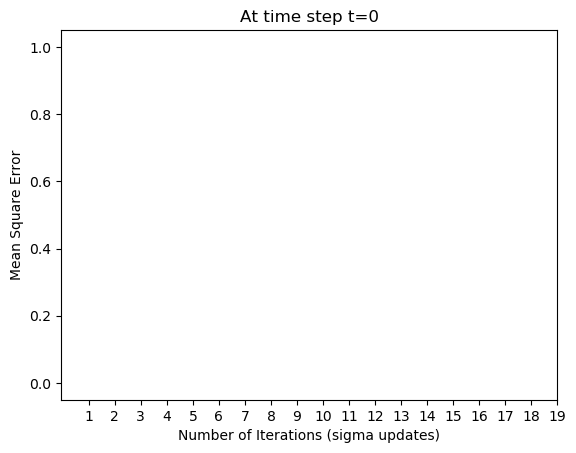

In [200]:
plt.plot(np.array(MSE_t0))
plt.xlabel('Number of Iterations (sigma updates)')
plt.xticks(range(1,20))
plt.ylabel('Mean Square Error')
plt.title('At time step t={}'.format(0))
plt.show